Perform all necessary imports

In [1]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
from vindy import SindyNetwork
from vindy.libraries import PolynomialLibrary
from vindy.layers import SindyLayer, VindyLayer
from vindy.layers.distributions import Gaussian, Laplace
from vindy.callbacks import (
    SaveCoefficientsCallback,
)
from Roessler_utils import data_generation, generate_directories, data_plot, training_plot, trajectory_plot, uq_plot


## Roessler System
The Roessler system is a system of three ordinary differential equations that describe a simple chaotic system. The equations are given by: 
$ \dot{z}_1 = -z_2 - z_3 $
$ \dot{z}_2 = z_1 + 0.2*z_2 $
$ \dot{z}_3 = 0.2 + z_3(z_1-5.7) = 0.2 + z_3 z_1 - 5.7z_3 $

In [2]:
def roessler(t, x0, a=0.2, b=0.2, c=5.7):
    x, y, z = x0
    return [-y - z, x + a * y, b + z * (x - c)]

Let's define some general script parameters

In [3]:
sindy_type = "vindy"  # "sindy" or "vindy"
model_name = "roessler"  # LV or roessler
seed = 29 # random seed
random_IC = True # use random initial conditions
random_a = True # use random parameters (a in the Roessler system)
measurement_noise_factor = 0.025 # measurement noise factor
model_noise_factor = 0.1 # model noise factor
n_train = 30 # number of training trajectories
n_test = 4 # number of test trajectories

Let's define directories for saving the results

In [4]:
# noise before derivative, model error, seed
scenario_info = f"{sindy_type}_nbd__me_{random_a}_{model_noise_factor}_seed_{seed}_noise_{measurement_noise_factor}"
_, _, _, weights_dir = generate_directories(model_name, sindy_type, scenario_info, "results")

First, we will generate the data for the Roessler system that we can use to train the VINDy model. We will use the `scipy.integrate.solve_ivp` function to solve the ODEs and generate the data. Let's plot the data to see what it looks like


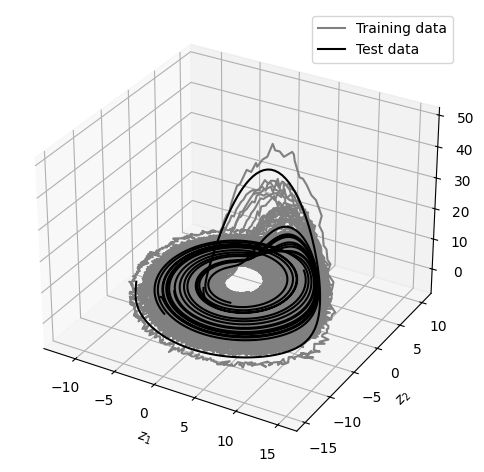

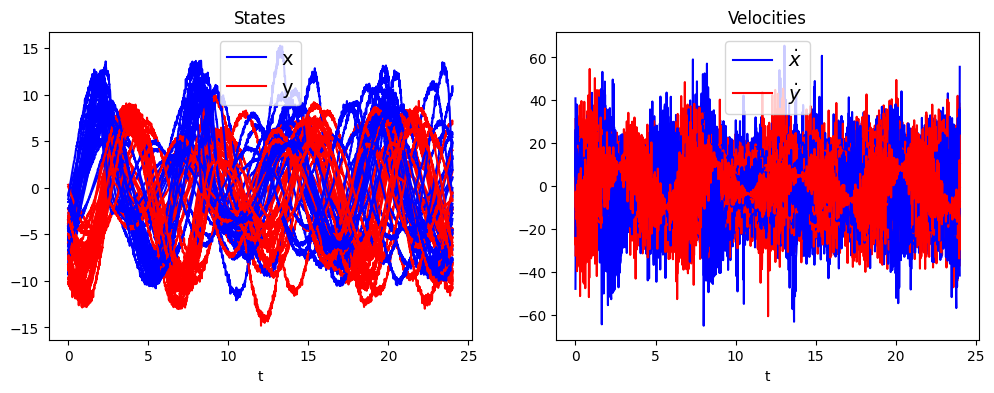

In [5]:
(
    t,
    x,
    dxdt,
    x_test,
    dxdt_test,
    var_names,
    dim
) = data_generation(roessler, n_train, n_test, random_IC, random_a, seed, model_noise_factor, measurement_noise_factor)

data_plot(t, x, dxdt, x_test)


## Model Generation

Now, we will define the VINDy model and train it on the generated data to learn the Roessler system. We will use the `VariationalSindyLayer` to define the model. The `VariationalSindyLayer` is a Bayesian version of the SINDy model that uses a variational inference approach to learn the model coefficients. We will use the `Laplacian` priors for the coefficients and use a polynomial library of degree 2 to learn the model.

In [6]:
# reshape data to fit the model
x_train = np.concatenate(x, axis=0)
dxdt_train = np.concatenate(dxdt, axis=0)
x_test = np.concatenate(x_test, axis=0)
dxdt_test = np.concatenate(dxdt_test, axis=0)

# model parameters
libraries = [
    PolynomialLibrary(2, include_bias=True),
]
dt = t[1] - t[0]

# create sindy layer
layer_params = dict(
    state_dim=x_train.shape[1],
    param_dim=0,
    feature_libraries=libraries,
    second_order=False,
    mask=None,
    kernel_regularizer=tf.keras.regularizers.L1L2(l1=0, l2=0),
)
if sindy_type == "vindy":
    sindy_layer = VindyLayer(
        beta=1e-3,
        priors=Laplace(0.0, 1.0),
        **layer_params,
    )
elif sindy_type == "sindy":
    sindy_layer = SindyLayer(
        **layer_params,
    )
else:
    raise ValueError(f"Unknown SINDy type: {sindy_type}")
    
# create autoencoder sindy model
model = SindyNetwork(
    sindy_layer=sindy_layer,
    x=x_train,
    l_dz=1e0,
    dt=dt,
    second_order=False,
)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="huber")

Let's train the VINDy model on the (noisy) Roessler data

In [7]:
weights_path = os.path.join(weights_dir, ".weights.h5")

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(weights_path),
        save_weights_only=True,
        save_best_only=True,
        monitor="loss",
        verbose=0,
    ),
    SaveCoefficientsCallback()
]

trainhist = model.fit(
    x=[x_train, dxdt_train],
    callbacks=callbacks,
    y=None,
    epochs=500,
    batch_size=256,
    verbose=2,
)
# load best weights
model.load_weights(os.path.join(weights_path))
# apply pdf threshold
sindy_layer.pdf_thresholding(threshold=0.5)

Epoch 1/500
235/235 - 1s - 4ms/step - dz: 72.0919 - kl_sindy: 0.0080 - loss: 72.1000 - reg: 0.0000e+00 - coeffs_mean: 6.9760e-04 - coeffs_scale: -4.9052e-02
Epoch 2/500
235/235 - 0s - 423us/step - dz: 60.5710 - kl_sindy: 0.0076 - loss: 60.5786 - reg: 0.0000e+00 - coeffs_mean: 0.0124 - coeffs_scale: -1.2702e-01
Epoch 3/500
235/235 - 0s - 420us/step - dz: 54.1711 - kl_sindy: 0.0075 - loss: 54.1786 - reg: 0.0000e+00 - coeffs_mean: 0.0120 - coeffs_scale: -2.0371e-01
Epoch 4/500
235/235 - 0s - 431us/step - dz: 47.3104 - kl_sindy: 0.0077 - loss: 47.3181 - reg: 0.0000e+00 - coeffs_mean: 0.0104 - coeffs_scale: -2.7633e-01
Epoch 5/500
235/235 - 0s - 424us/step - dz: 44.0539 - kl_sindy: 0.0080 - loss: 44.0620 - reg: 0.0000e+00 - coeffs_mean: 0.0211 - coeffs_scale: -3.5365e-01
Epoch 6/500
235/235 - 0s - 438us/step - dz: 38.9378 - kl_sindy: 0.0086 - loss: 38.9464 - reg: 0.0000e+00 - coeffs_mean: 0.0251 - coeffs_scale: -4.2877e-01
Epoch 7/500
235/235 - 0s - 425us/step - dz: 34.6297 - kl_sindy: 0.00

INFO:root:Canceling coefficient 1
INFO:root:Canceling coefficient z_0
INFO:root:Canceling coefficient z_0^2
INFO:root:Canceling coefficient z_0*z_1
INFO:root:Canceling coefficient z_0*z_2
INFO:root:Canceling coefficient z_1^2
INFO:root:Canceling coefficient z_1*z_2
INFO:root:Canceling coefficient z_2^2
INFO:root:Canceling coefficient 1
INFO:root:Canceling coefficient z_2
INFO:root:Canceling coefficient z_0^2
INFO:root:Canceling coefficient z_0*z_1
INFO:root:Canceling coefficient z_0*z_2
INFO:root:Canceling coefficient z_1^2
INFO:root:Canceling coefficient z_1*z_2
INFO:root:Canceling coefficient z_2^2
INFO:root:Canceling coefficient z_0
INFO:root:Canceling coefficient z_1
INFO:root:Canceling coefficient z_0^2
INFO:root:Canceling coefficient z_0*z_1
INFO:root:Canceling coefficient z_1^2
INFO:root:Canceling coefficient z_1*z_2


dz0 = - 0.994*z1 - 0.993*z2 
dz1 = + 0.994*z0 + 0.212*z1 
dz2 = + 0.197*1 - 5.093*z2 + 0.946*z0*z2 - 0.013*z2^2 


Let's plot the training history of the VINDy model and check how the coefficients evolved during training. 
We plot the coefficients of the VINDy model to see which terms are learned by the model. 

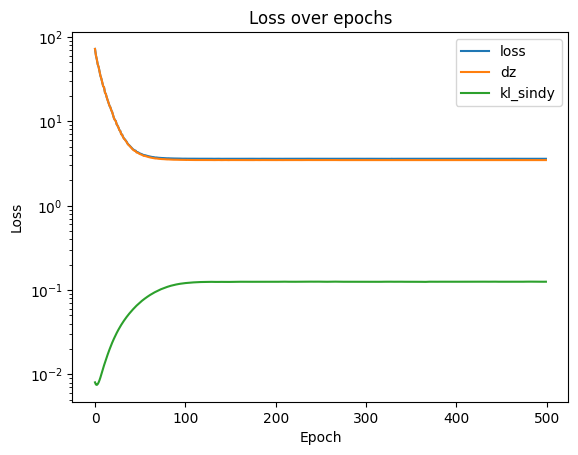

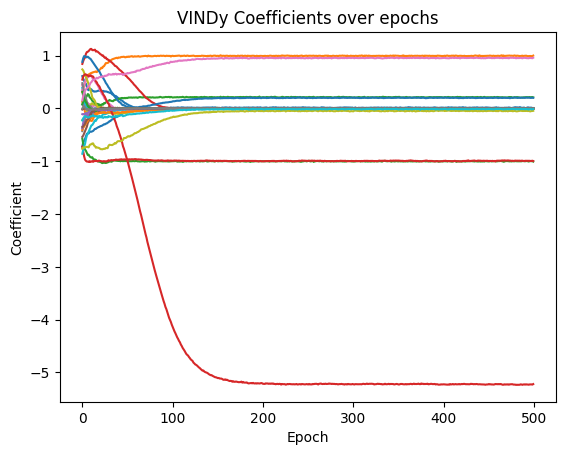

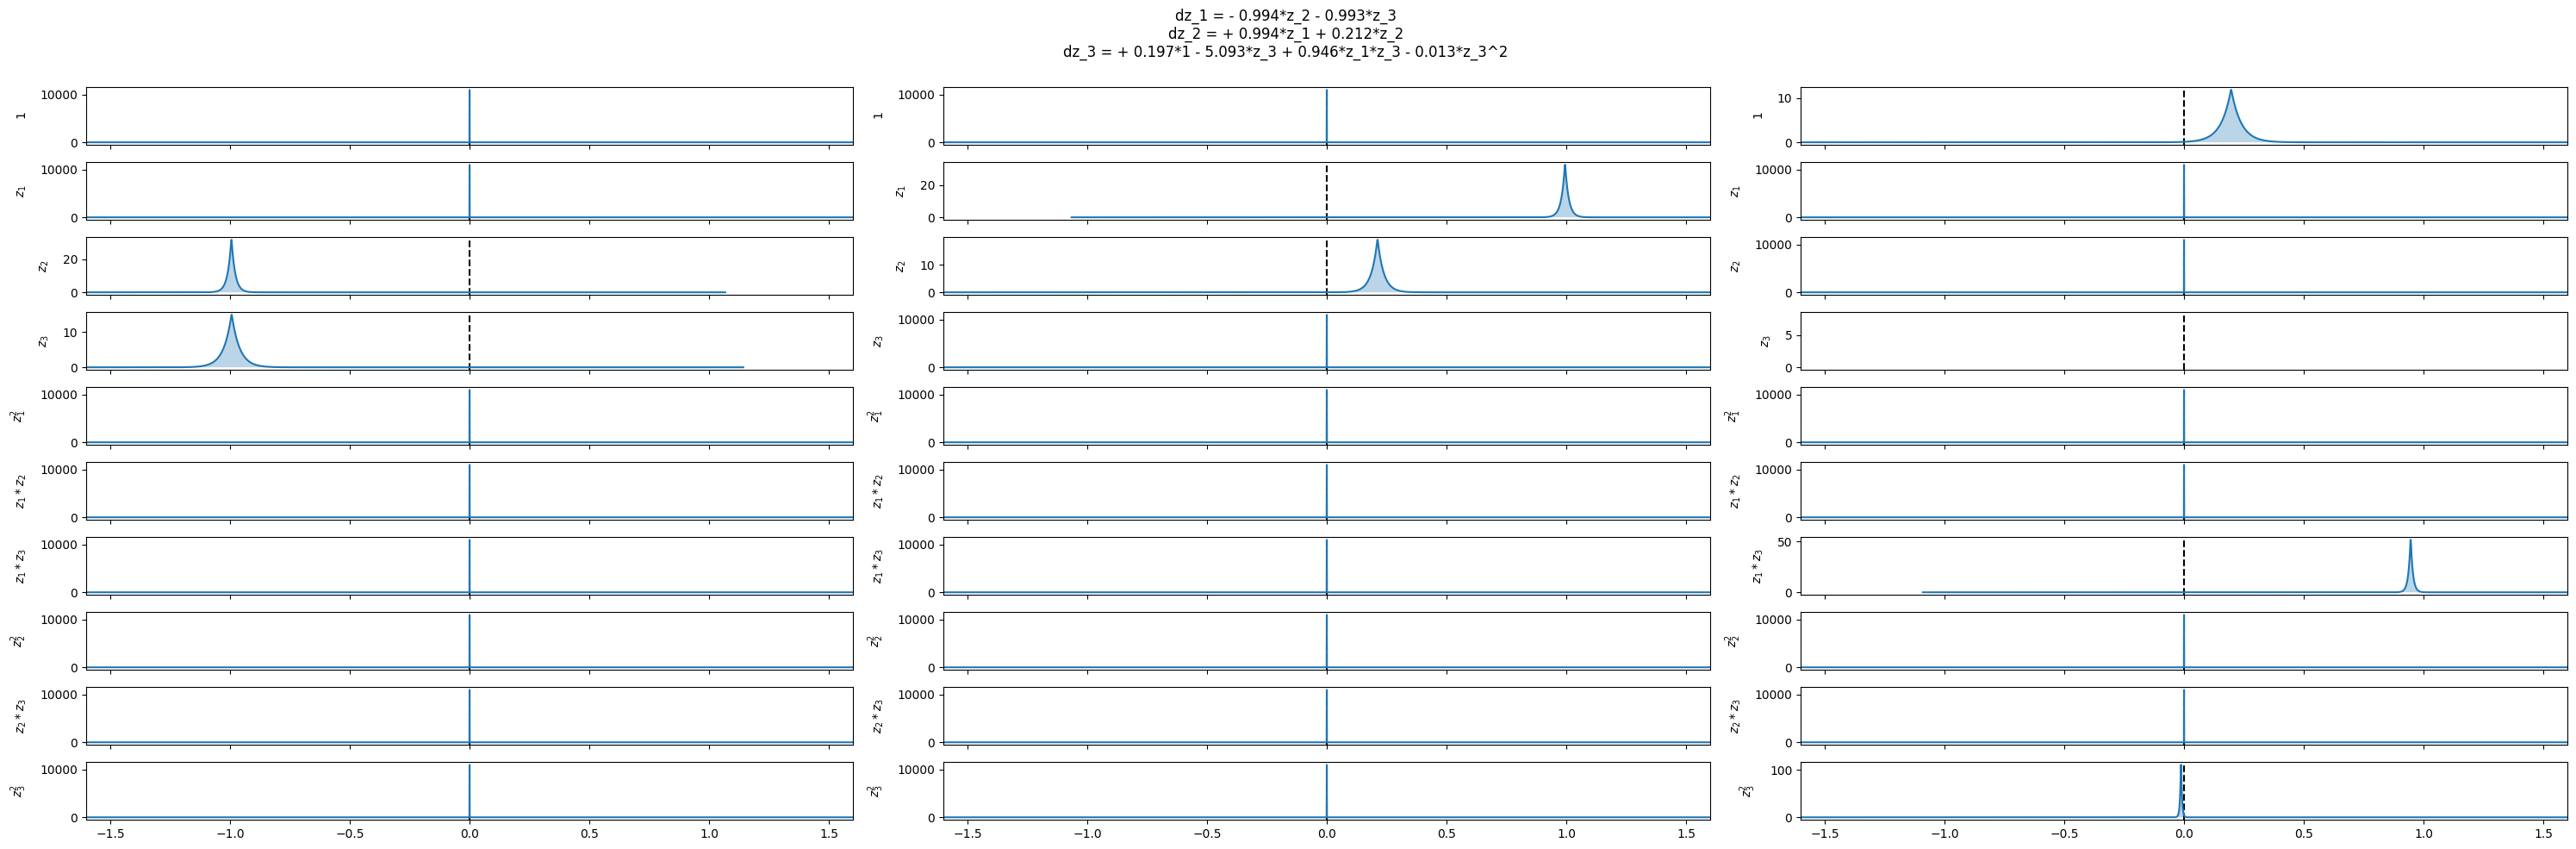

In [8]:
# plot training history
training_plot(sindy_layer, trainhist, var_names)

We can now use the trained VINDy model to predict the future states of the Roessler system. We will use the scipy.integrate.solve_ivp function to integrate the ODEs using the predicted time derivatives. 

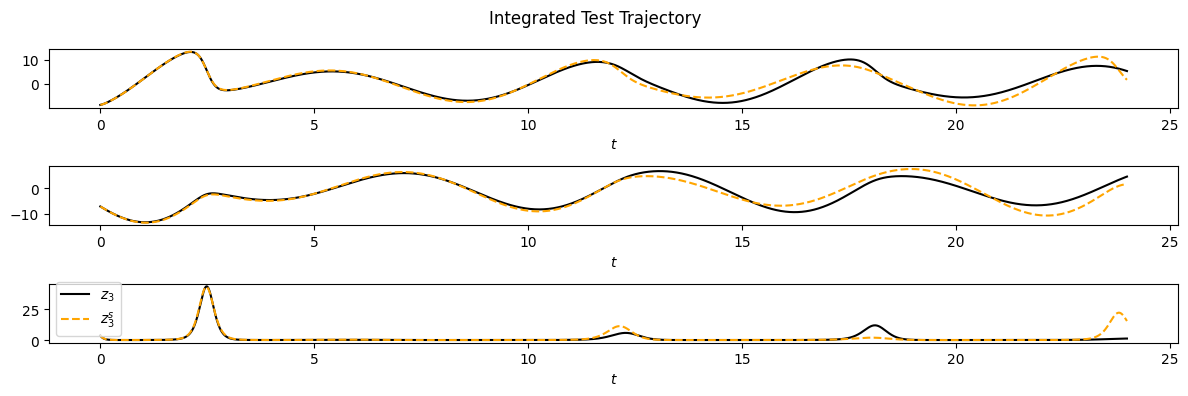

In [9]:
# %% integration
nt = t.shape[0]
i_test = 2
# integrate the model
t_0 = i_test * int(nt)
sol = model.integrate(x_test[t_0 : t_0 + 1].squeeze(), t.squeeze(), mu=None)
t_pred = sol.t
x_pred = sol.y

trajectory_plot(t, x_test, t_pred, x_pred, dim, nt, i_test, var_names)

## Uncertainty quantification
Instead of only using the mean coefficients for a single prediction, we can also sample various models and use them to predict the future states of the Roessler system. This will give us an idea of the uncertainty in the model predictions.
Forward UQ:
* We sample SINDy coefficients from the predicted posterior distribution
* We integrate the ODE with the sampled coefficients and collect the trajectories

In [10]:
n_traj = 10
# Store the original coefficients
kernel_orig, kernel_scale_orig = sindy_layer.kernel, sindy_layer.kernel_scale

t_preds = []
x_preds = []
t_0 = i_test * int(nt)
print(f"test trajectory {i_test}")
# List to store the solution trajectories in latent space
for traj in range(n_traj):
    print(f"\t sample {traj+1} out of {n_traj}")
    # Sample from the posterior distribution of the coefficients
    sampled_coeff, f_, ff_ = sindy_layer._coeffs
    # only take non-zero coefficients
    sampled_coeff = sampled_coeff.numpy()
    sampled_coeff = sampled_coeff[sampled_coeff != 0]

    # Assign the sampled coefficients to the SINDy layer
    sindy_layer.kernel = tf.reshape(sampled_coeff, (-1, 1))
    sol = model.integrate(x_test[t_0:t_0 + 1].squeeze(),
                          t.squeeze())
    t_preds.append(sol.t)
    x_preds.append(sol.y)
# restore original coefficients
sindy_layer.kernel, sindy_layer.kernel_scale = kernel_orig, kernel_scale_orig
# calculate mean and variance of the trajectories
x_uq = np.array(x_preds)
x_uq_mean_sampled = np.mean(x_uq, axis=0)
x_uq_std = np.std(x_uq, axis=0)
# UQ plot
uq_plot(t, x_test, t_preds, x_pred, x_uq_mean_sampled, x_uq_std, dim, nt, i_test)

test trajectory 2
	 sample 1 out of 10
	 sample 2 out of 10
	 sample 3 out of 10
	 sample 4 out of 10
	 sample 5 out of 10
	 sample 6 out of 10
	 sample 7 out of 10
	 sample 8 out of 10
	 sample 9 out of 10
	 sample 10 out of 10


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (10, 3) + inhomogeneous part.